<a href="https://colab.research.google.com/github/zchuning/PublicSchoolDataAnalysis/blob/master/Copy_of_Copy_of_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Data Loading



In [0]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scikit-learn

### Loading data into collab

1.   Open the file browsing menu by clicking on the tab with a right pointing
arrow.
2.   Navigate to each directories parent until you reach the root.
3.   Upload "MA_Public_Schools_2017.csv" and "MA_Public_Schools_datadict.csv".
4.   Run the code blocks below.



In [0]:
# Relevant module imports are all located here.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.io import arff
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, accuracy_score, classification_report

In [0]:
# Load the bankruptcy data into two pandas dataframes
data, meta = arff.loadarff('/2year.arff')
data = np.array(data.tolist(), np.float)

X = data[:, :-1]
y = data[:, -1]

In [0]:
X.shape

(10173, 64)

# Data Imputation

In [0]:
# Zero imputation function
def zeroImpute(X_miss):
  '''
  Returns :
  X_imputed which has zeroes instead of missing values and same shape as X_miss.
  '''
  return np.nan_to_num(X_miss.copy())

In [0]:
# Regression imputation function
def regressedImpute(X_baseImputed, X_miss):
  '''
  Returns :
    X_imputed which has mean of the linearly regressed value instead of the missing values and same shape as X_miss.
  if computePerFeatureStatistics is True, also:
    list of Frobenius norms of difference between reconstructions and original data (without missing values) calculated after each imputing each column.
    list of accuracies on test set of Logistic Regression classifier trained on imputed data after each imputing each column.
  '''
  X_imputed = X_baseImputed.copy()
  # We do a linear regression based imputation here, for each column, train a 
  # classifier to predict its value based on values of other features and
  # replace the NaN with the predicted values. 

  for j in range(X_baseImputed.shape[1]):
    # Build model for current column
    selector = [x for x in range(X_baseImputed.shape[1]) if x != j]
    X_filtered = X_baseImputed[~np.isnan(X_miss[:,j])]
    y_filtered = X_filtered[:,j]
    X_filtered = X_filtered[:, selector]
    col_clf = LinearRegression().fit(X_filtered, y_filtered)

    # Replace X_imputed with new values using new model
    for i in range(X_miss.shape[0]):
      if np.isnan(X_miss[i, j]):
        X_imputed[i, j] =\
          col_clf.predict(X_baseImputed[i, selector].reshape(1, -1))
  
  return X_imputed

In [0]:
# Epoch regression imputation
def impute(X_miss, epochs=2):
  X_imputed = zeroImpute(X_miss.copy())
  for _ in range(epochs):
    X_imputed = regressedImpute(X_imputed, X_miss)
  return X_imputed

In [0]:
X_imputed = impute(X)

In [0]:
X_pos = X_imputed[y == 1]
y_pos = y[y == 1]
X_neg = X_imputed[y == 0]
y_neg = y[y == 0]

# pos_split = int(len(y_pos) * 0.7)
# neg_split = int(len(y_neg) * 0.7)

# X_train = np.concatenate((X_neg[:neg_split], X_pos[:pos_split]))
# y_train = np.concatenate((y_neg[:neg_split], y_pos[:pos_split]))

# X_test = np.concatenate((X_neg[neg_split:], X_pos[pos_split:]))
# y_test = np.concatenate((y_neg[neg_split:], y_pos[pos_split:]))

In [0]:
indices = random.sample(range(1, len(X_neg)-1), 800)
X_neg = X_neg[indices]
y_neg = y_neg[indices]

pos_split = int(len(y_pos) * 0.7)
neg_split = int(len(y_neg) * 0.7)

X_train = np.concatenate((X_neg[:neg_split], X_pos[:pos_split]))
y_train = np.concatenate((y_neg[:neg_split], y_pos[:pos_split]))

X_test = np.concatenate((X_neg[neg_split:], X_pos[pos_split:]))
y_test = np.concatenate((y_neg[neg_split:], y_pos[pos_split:]))

In [0]:
def plot_line_graph(x_vals, y_vals_1, y_vals_2, y_vals_1_label, y_vals_2_label, x_axis_label, y_axis_label, title):
    """
    Plots a line graph of two lines of different values with common x-values

    Args:
    x_vals ((j,) list): Values to be displayed on horizontal axis, where j is number of values
    y_vals_1 ((j,) list): First set of values to be graphed on a line in respect to x_vals, where j is number of values
    y_vals_2 ((j,) list): Second set of values to be graphed on a line in respect to x_vals, where j is number of values
    y_vals_1_label (string): Label for first set of y values
    y_vals_2_label (string): Label for second set of y values
    x_axis_label (string): Label for x axis
    y_axis_label (string): Label for y axis
    title (string): Plot title
    """ 

    plt.plot(x_vals, y_vals_1, color='g', label=y_vals_1_label)
    plt.plot(x_vals, y_vals_2, color='orange', label=y_vals_2_label)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

In [0]:
n_estimators = [5, 10, 25, 50, 75, 100, 125, 150]
accuracies = []
precisions = []

print("<<<<TEST DATA PREDICTIONS FOR RANDOM FOREST>>>>")

for i in range(len(n_estimators)):
  clf = RandomForestClassifier(n_estimators=n_estimators[i], max_depth=6)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accScore = accuracy_score(y_test, y_pred)
  accuracies.append(accScore)
  precScore = precision_score(y_test, y_pred)
  precisions.append(precScore)
  print("# Estimators: " + str(n_estimators[i]) + ", Accuracy: " + str(accScore) + ", Precision: " + str(precScore))

<<<<TEST DATA PREDICTIONS FOR RANDOM FOREST>>>>
# Estimators: 5, Accuracy: 0.7361111111111112, Precision: 0.654320987654321
# Estimators: 10, Accuracy: 0.7805555555555556, Precision: 0.7662337662337663
# Estimators: 25, Accuracy: 0.7666666666666667, Precision: 0.78125
# Estimators: 50, Accuracy: 0.7666666666666667, Precision: 0.7903225806451613
# Estimators: 75, Accuracy: 0.7638888888888888, Precision: 0.7611940298507462
# Estimators: 100, Accuracy: 0.7694444444444445, Precision: 0.7681159420289855
# Estimators: 125, Accuracy: 0.7638888888888888, Precision: 0.7777777777777778
# Estimators: 150, Accuracy: 0.7638888888888888, Precision: 0.7536231884057971


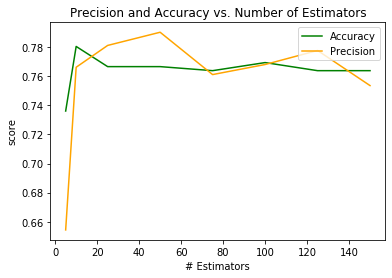

In [0]:
plot_line_graph(n_estimators, accuracies, precisions, "Accuracy", "Precision", "# Estimators", "score", "Precision and Accuracy vs. Number of Estimators")

In [0]:
K = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33]
accuracies = []
precisions = []
print("<<<<TEST DATA PREDICTIONS FOR KNN>>>>")

for i in range(len(K)):
  neigh = KNeighborsClassifier(n_neighbors=K[i], p=2)
  neigh.fit(X_train, y_train)
  y_pred = neigh.predict(X_test)
  accScore = accuracy_score(y_test, y_pred)
  accuracies.append(accScore)
  precScore = precision_score(y_test, y_pred)
  precisions.append(precScore)
  print("K: " + str(K[i]) + ", Accuracy: " + str(accScore) + ", Precision: " + str(precScore))

<<<<TEST DATA PREDICTIONS FOR KNN>>>>
K: 1, Accuracy: 0.6083333333333333, Precision: 0.6140350877192983
K: 3, Accuracy: 0.6458333333333334, Precision: 0.6548672566371682
K: 5, Accuracy: 0.6291666666666667, Precision: 0.6347826086956522
K: 7, Accuracy: 0.6208333333333333, Precision: 0.6283185840707964
K: 9, Accuracy: 0.6333333333333333, Precision: 0.6538461538461539
K: 11, Accuracy: 0.6375, Precision: 0.6460176991150443
K: 13, Accuracy: 0.625, Precision: 0.6339285714285714
K: 15, Accuracy: 0.6583333333333333, Precision: 0.6583333333333333
K: 17, Accuracy: 0.6541666666666667, Precision: 0.6581196581196581
K: 19, Accuracy: 0.6375, Precision: 0.6386554621848739
K: 21, Accuracy: 0.6333333333333333, Precision: 0.6379310344827587
K: 23, Accuracy: 0.6333333333333333, Precision: 0.6428571428571429
K: 25, Accuracy: 0.6375, Precision: 0.6513761467889908
K: 27, Accuracy: 0.65, Precision: 0.6551724137931034
K: 29, Accuracy: 0.6375, Precision: 0.6386554621848739
K: 31, Accuracy: 0.6416666666666667, 

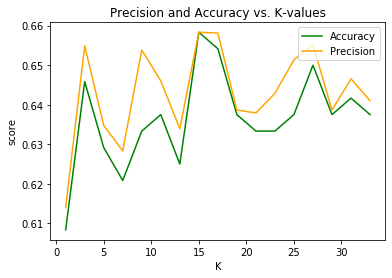

In [0]:
plot_line_graph(K, accuracies, precisions, "Accuracy", "Precision", "K", "score", "Precision and Accuracy vs. K-values")

In [0]:
cls = LogisticRegression()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>")
print("Accuracy: " + str(accuracy) + ", Precision: " + str(precision))

<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>
Accuracy: 0.6583333333333333, Precision: 0.6938775510204082


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
cls = SVC(gamma='auto')
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("<<<<TEST DATA PREDICTIONS FOR SVM RBF KERNAL>>>>")
print("Accuracy: " + str(accuracy) + ", Precision: " + str(precision))

<<<<TEST DATA PREDICTIONS FOR SVM RBF KERNAL>>>>
Accuracy: 0.5, Precision: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
